# Preprocessing

**Steps:**
1. The Denmark LPIS vector geometries are cleaned and simplified, the labels are reclassified to 5 crop classes.
2. The Sentinel-2 RGB-imagery is cut to 128x128-pixel image chips.
3. The prepared LPIS data is clipped to the chip geometries and saved in COCO annotation format.

Due to file size limitations, this repository only contains vector and satellite image data for a small subset of the full area of interest. The preprocessing of this demonstration data (area around Frederiksen, Denmark) results in 9 image chips. To work on the full dataset as presented in the thesis, you can download:
- [2016 LPIS dataset](https://kortdata.fvm.dk/download/Markblokke_Marker?page=MarkerHistoriske) ("Marker_2016_CVR.zip") via the Danish Ministery of Environment
- [Sentinel-2 mosaic](https://code.earthengine.google.com/c9ac3a79660b65525cfa59f1087cea9b) (2016/05/08, tiles 32VNH&T32UNG) via this Google Earth Engine script.

![](figures/preprocessing_demo.jpg)

## clone Utils from git and install requirements

In [1]:
!git clone https://github.com/mrshamshir/InstanceSegmentation_MaskRCNN.git
%cd InstanceSegmentation_MaskRCNN/

Cloning into 'InstanceSegmentation_MaskRCNN'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 48 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (48/48), done.
/content/InstanceSegmentation_MaskRCNN


In [2]:
!pip install rasterio
!pip install geopandas

     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 
     |████████████████████████████████| 6.3 MB 39.5 MB/s 


### import libraries

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
import shapely
from pprint import pprint

from utils import geo , other, img, coco

## Vector preparation

In [4]:
image = '/content/drive/MyDrive/Denmark/mosaic_denmark_T32VNH_T32UNG.tif'
shape='/content/drive/MyDrive/Marker_2016_CVR/Marker_2016_CVR.shp'


inpath_s2 = Path(image)
inpath_fields = Path(shape)

outpath = Path(r'/content/drive/MyDrive/preprocessed/newsmall/')

In [5]:
def prepare_vector(fp, out_crs, clipping_bounds):
    df = (gpd.read_file(str(fp), encoding='cp865')  # danish encoding
             .rename(columns={'Afgroede': 'lc_name', 'Afgkode': 'lc_id', 'Journalnr': 'journalnr'})
             .drop(['GB', 'IMK_areal', 'Marknr'], axis=1)
             .pipe(geo.explode_mp)
             .pipe(geo.buffer_zero)
             .pipe(geo.close_holes).pipe(geo.print_len, caller='close holes')
            #  .pipe(utils.geo.set_crs, 3044)
            #  .to_crs(out_crs).pipe(geo_print_len, caller='crs')
             .pipe(geo.clip, clip_poly=shapely.geometry.box(*clipping_bounds), explode_mp_=True).pipe(geo.print_len, caller='clipper')
             .pipe(geo.reclassify_col, rcl_scheme=geo.reclass_legend, 
                   col_classlabels='lc_name', col_classids='lc_id', drop_other_classes=True).pipe(geo.print_len, caller='reclass')
             .assign(geometry=lambda _df: _df.geometry.simplify(5, preserve_topology=True))
             .pipe(geo.buffer_zero)
             .assign(area_sqm=lambda _df: _df.geometry.area)
             .pipe(geo.reduce_precision, precision=4).pipe(geo.print_len, caller='semi final')
             .reset_index(drop=True)
             .assign(fid=lambda _df: range(0, len(_df.index)))
             .filter(['journalnr', 'lc_id', 'lc_name', 'r_lc_id', 'r_lc_name', 'area_sqm', 'fid', 'geometry']))
    return df

outpath_fields = outpath / 'prepared_vector.shp'

if not outpath_fields.exists():
    with rasterio.open(inpath_s2) as src:
        raster_meta = src.meta
        raster_bounds = src.bounds
    df = prepare_vector(inpath_fields, raster_meta['crs'], raster_bounds)
    outpath_fields.parent.mkdir(parents=True, exist_ok=True)
    df.to_file(outpath_fields, driver='ESRI Shapefile', encoding='cp865')
else:
    print(f'Loading from exisiting shp file... {outpath_fields.name}')
    df = gpd.read_file(str(outpath_fields), encoding='cp865')
    
print(df.info())
display(df.head(3))

caller:close holes, nr_polys: 599922
caller:clipper, nr_polys: 249690
caller:reclass, nr_polys: 159037
caller:semi final, nr_polys: 159037
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 159037 entries, 0 to 159036
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   journalnr  159037 non-null  object  
 1   lc_id      159037 non-null  float64 
 2   lc_name    159037 non-null  object  
 3   r_lc_id    159037 non-null  int64   
 4   r_lc_name  159037 non-null  object  
 5   area_sqm   159037 non-null  float64 
 6   fid        159037 non-null  int64   
 7   geometry   159037 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(3)
memory usage: 9.7+ MB
None


,journalnr,lc_id,lc_name,r_lc_id,r_lc_name,area_sqm,fid,geometry
0,16-0032765,10.0,Vinterbyg,2,wintercereal,82352.519030,0,"POLYGON ((548746.858 6213228.194, 548888.985 6..."
1,16-0039172,11.0,Vinterhvede,2,wintercereal,43861.200588,1,"POLYGON ((607014.582 6103822.936, 607253.843 6..."
2,16-0039346,1.0,Vσrbyg,1,springcereal,7112.095784,2,"POLYGON ((590215.945 6243075.135, 590263.301 6..."


## Cut to chips

### Clip vectors to chip geometries

In [7]:
outpath_chips = outpath / 'chip_dfs.pkl'
chip_width, chip_height = 128, 128

if not outpath_chips.exists():
    with rasterio.open(inpath_s2) as src:
        raster_meta = src.meta
    chip_dfs = geo.cut_chip_geometries(vector_df=df,
                                        raster_width=raster_meta['width'],
                                        raster_height=raster_meta['height'],
                                        raster_transform=raster_meta['transform'],
                                        chip_width=chip_width,
                                        chip_height=chip_height,
                                        first_n_chips = None)
    other.new_pickle(outpath_chips, chip_dfs)
else:
    chip_dfs = other.load_pickle(outpath_chips)
print(len(chip_dfs))

5191it [50:09,  1.70it/s]

GEOMETRYCOLLECTION (POINT (539852.22 6124660), POLYGON ((540112.4731399824 6124660, 540123.85 6124591.48, 540159.23 6124496.46, 540108.66 6124476.1, 540100.62 6124494.61, 540081.5699999999 6124489.65, 540058.1800000001 6124551.53, 539995.6071688542 6124660, 540112.4731399824 6124660)))
POLYGON ((540112.4731399824 6124660, 540123.85 6124591.48, 540159.23 6124496.46, 540108.66 6124476.1, 540100.62 6124494.61, 540081.5699999999 6124489.65, 540058.1800000001 6124551.53, 539995.6071688542 6124660, 540112.4731399824 6124660))


13855it [2:13:20,  1.73it/s]


deleted small fields: 42620
Writing new pickle file... chip_dfs.pkl
10434


### Convert chip vectors to COCO annotation format (contains test/test split) and export.

In [8]:
train_chip_dfs, val_chip_dfs = coco.train_test_split(chip_dfs, test_size=0.2, seed=1)

coco_train = coco.format_coco(train_chip_dfs, chip_width, chip_height,multi=False)
coco_val = coco.format_coco(val_chip_dfs, chip_width, chip_height,multi=False)

other.new_json(outpath / r'annotations/single_instances_train2016.json', coco_train)
other.new_json(outpath / r'annotations/single_instances_val2016.json', coco_val)

coco_train = coco.format_coco(train_chip_dfs, chip_width, chip_height,multi=True)
coco_val = coco.format_coco(val_chip_dfs, chip_width, chip_height,multi=True)

other.new_json(outpath / r'annotations/multi_instances_train2016.json', coco_train)
other.new_json(outpath / r'annotations/multi_instances_val2016.json', coco_val)

Writing new json file... single_instances_train2016.json
Writing new json file... single_instances_val2016.json
Writing new json file... multi_instances_train2016.json
Writing new json file... multi_instances_val2016.json


### Crop images to chips

In [9]:
# Cut to chip images and write to disk, retrieve chip image statistics
    
chip_windows = {chip_name : value['chip_window'] for chip_name, value in chip_dfs.items()}
chip_statistics = img.cut_chip_images(inpath_raster=inpath_s2,
                                            outpath_chipfolder=outpath / r'images/train2016',  
                                            chip_names=chip_windows.keys(),
                                            chip_windows=chip_windows.values(), 
                                            bands=[3, 2, 1])

coco.move_coco_val_images(inpath_train_folder=outpath / r'images/train2016',
                                val_chips_list=val_chip_dfs.keys())

print('len', len(chip_statistics))

10434it [03:34, 48.58it/s]


val path:  /content/drive/MyDrive/preprocessed/newsmall/images/val2016
len 10434


## Save statistics & visualize results

The statistics are partially used as model training parameters.

In [10]:
statistics = {
    'nr_chips': len(chip_dfs.keys()),
    'nr_chips_train': len(train_chip_dfs),
    'nr_chips_val': len(val_chip_dfs),
    'nr_polys': sum([len(df['chip_df']) for df in chip_dfs.values()]),
    'nr_polys_train': sum([len(df['chip_df']) for df in train_chip_dfs.values()]),
    'nr_polys_val': sum([len(df['chip_df']) for df in val_chip_dfs.values()]),
    'avg_polys_per_chip': sum([len(df['chip_df']) for df in chip_dfs.values()]) / len(chip_dfs.keys()),
    'train_rgb_mean': list(np.asarray([df['mean'] for df in [chip_statistics[key] for key in train_chip_dfs.keys()]]).mean(axis=0)),
    'train_rgb_std': list(np.asarray([df['std'] for df in [chip_statistics[key] for key in train_chip_dfs.keys()]]).mean(axis=0))
    }

other.new_json(outpath / 'statistics.json', statistics)
pprint(statistics)

Writing new json file... statistics.json
{'avg_polys_per_chip': 18.6522905884608,
 'nr_chips': 10434,
 'nr_chips_train': 8347,
 'nr_chips_val': 2087,
 'nr_polys': 194618,
 'nr_polys_train': 155633,
 'nr_polys_val': 38985,
 'train_rgb_mean': [91.37227669278633, 107.08803873415177, 116.13283816591571],
 'train_rgb_std': [36.92781850087702, 21.863307501890848, 18.340589100795302]}


Loading from existing json file... single_instances_val2016.json
COCO_val2016_000000100000.jpg


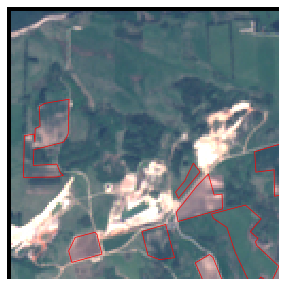

COCO_val2016_000000100007.jpg


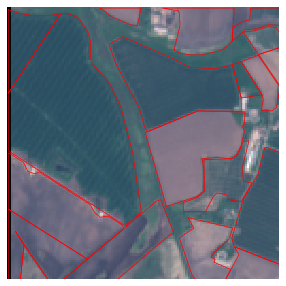

COCO_val2016_000000100011.jpg


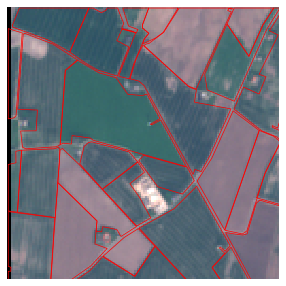

In [12]:
coco.plot_coco(inpath_json=outpath / r'annotations/single_instances_val2016.json', 
                     inpath_image_folder=outpath / r'images/val2016', 
                     end=3)

## save changes of colab to drive

In [ ]:
# !cp -r /content/drive/MyDrive/preprocessed/new/images /content/drive/MyDrive/preprocessed/newnew/
from google.colab import drive
drive.flush_and_unmount()